21/3/2021 Modified adding callbacks

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

import torch
import pytorch_tabnet

from pytorch_tabnet.tab_model import TabNetClassifier
from pytorch_tabnet.callbacks import Callback

import mlflow

from sklearn.preprocessing import LabelEncoder

In [2]:
# loading data
df_orig = pd.read_csv('cs-training-nonull.csv')

In [3]:
df_orig.head()

,id,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,isna_mi,isna_nod
0,1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0,0,0
1,2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0,0,0
2,3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0,0,0
3,4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0,0,0
4,5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0,0,0


In [4]:
df_orig.columns

Index(['id', 'SeriousDlqin2yrs', 'RevolvingUtilizationOfUnsecuredLines', 'age',
       'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome',
       'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
       'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse',
       'NumberOfDependents', 'isna_mi', 'isna_nod'],
      dtype='object')

In [5]:
data = df_orig.copy()

In [6]:
# columns that will be used
PREDICTOR = 'SeriousDlqin2yrs'

unused_feat = ['id']

num_col_list = ['RevolvingUtilizationOfUnsecuredLines','DebtRatio', 'MonthlyIncome']

cat_col_list = ['age', 'NumberOfTime30-59DaysPastDueNotWorse', 'NumberOfOpenCreditLinesAndLoans', 
                'NumberOfTimes90DaysLate', 'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse',
               'NumberOfDependents']

all_col_list = num_col_list + cat_col_list

In [7]:
# encode cat features (with label encoder)
nunique = data.nunique()
types = data.dtypes

categorical_columns = cat_col_list
categorical_dims =  {}

# I need to save the encoder list for the processing of the test set
enc_list = []
 
for col in cat_col_list:
    print(col, data[col].nunique())
    l_enc = LabelEncoder()
    data[col] = l_enc.fit_transform(data[col].values)
    
    # save the encoder for the test set
    enc_list.append(l_enc)
    categorical_dims[col] = len(l_enc.classes_)

age 86
NumberOfTime30-59DaysPastDueNotWorse 16
NumberOfOpenCreditLinesAndLoans 58
NumberOfTimes90DaysLate 19
NumberRealEstateLoansOrLines 28
NumberOfTime60-89DaysPastDueNotWorse 13
NumberOfDependents 13


In [8]:
# split data in train, validation
FRAC = 0.8

N_TRAIN = int(data.shape[0] * FRAC)
N_VALID = data.shape[0] - N_TRAIN

# before splitting, shuffle
data = data.sample(frac = 1)

df_train = data[:N_TRAIN]
df_valid = data[N_TRAIN:]

print('Number of records in train dataset:', N_TRAIN)
print('Number of records in validation dataset:', N_VALID)

Number of records in train dataset: 120000
Number of records in validation dataset: 30000


In [9]:
label_train = df_train[PREDICTOR].values
label_valid = df_valid[PREDICTOR].values

df_train = df_train[all_col_list]
df_valid = df_valid[all_col_list]

In [10]:
features = [ col for col in df_train.columns if col not in unused_feat+[PREDICTOR]] 

cat_idxs = [ i for i, f in enumerate(features) if f in categorical_columns]

cat_dims = [ categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]

In [11]:
print('Index of cat colums:', cat_idxs)

Index of cat colums: [3, 4, 5, 6, 7, 8, 9]


In [12]:
print('Cardinality of cat columns:', cat_dims)

Cardinality of cat columns: [86, 16, 58, 19, 28, 13, 13]


In [13]:
# MLFLOW, configuration, for the callback

MLF_TRACK_URI = 'http://130.61.20.111:5000'
MLF_EXP_NAME = 'tabnet21gpu'
MLF_RUN_NAME = 'tabnet21gpu-1'

In [14]:
#
# Hyper-parameters
#
params = {
    "epochs" : 50,
    "batch_size" : 2048,
    "n_steps" : 2,
    "n_d" : 32,
    "cat_emb_dim" : 2
}

In [15]:
#
# callback for MLFlow integration
#
class MLCallback(Callback):
    def on_train_begin(self, logs=None):
        
        mlflow.set_tracking_uri(MLF_TRACK_URI)
        mlflow.set_experiment(MLF_EXP_NAME)
        
        print('Train begin...')
        mlflow.start_run(run_name = MLF_RUN_NAME)
        
        mlflow.log_params(params)
        
    def on_train_end(self, logs=None):
        
        mlflow.end_run()
        print('Train end...')
        
    def on_epoch_end(self, epoch, logs=None):
        
        # print(logs)
        
        # send to MLFlow
        mlflow.log_metric("train_auc", logs['train_auc'])
        mlflow.log_metric("valid_auc", logs["valid_auc"])
        mlflow.log_metric("loss", logs["loss"])

In [16]:
# 
EPOCHS = params['epochs']
BATCH_SIZE = params['batch_size']
N_STEPS = params['n_steps']
CAT_EMB_DIM = params['cat_emb_dim']
N_D = params['n_d']
N_A = N_D

# callback for MLFlow integration
mlcbck = MLCallback()

clf = TabNetClassifier(cat_idxs=cat_idxs,
                       cat_dims=cat_dims,
                       cat_emb_dim=CAT_EMB_DIM,
                       optimizer_fn=torch.optim.Adam,
                       optimizer_params=dict(lr=5e-3),
                       scheduler_params={"step_size":10, # how to use learning rate scheduler
                                         "gamma":0.9},
                       scheduler_fn=torch.optim.lr_scheduler.StepLR,
                       mask_type='sparsemax',
                       n_steps = N_STEPS,
                       n_d = N_D,
                       n_a = N_A
                      )

clf.fit(df_train.values, label_train,
        eval_set=[(df_train.values, label_train),(df_valid.values, label_valid)],
        max_epochs = EPOCHS,
        batch_size = BATCH_SIZE,
        patience = 10,
        eval_name=['train', 'valid'],
        eval_metric=['auc'],
        callbacks = [mlcbck]
)

Device used : cpu
INFO: 'tabnet14' does not exist. Creating a new experiment
Train begin...
epoch 0  | loss: 0.31429 | train_auc: 0.65664 | valid_auc: 0.64494 |  0:00:33s
epoch 1  | loss: 0.21618 | train_auc: 0.71471 | valid_auc: 0.70108 |  0:01:07s
epoch 2  | loss: 0.21077 | train_auc: 0.75596 | valid_auc: 0.74373 |  0:01:37s
epoch 3  | loss: 0.20655 | train_auc: 0.77706 | valid_auc: 0.76952 |  0:02:07s
epoch 4  | loss: 0.20355 | train_auc: 0.7888  | valid_auc: 0.77871 |  0:02:37s
epoch 5  | loss: 0.20081 | train_auc: 0.79783 | valid_auc: 0.78738 |  0:03:06s
epoch 6  | loss: 0.20014 | train_auc: 0.8002  | valid_auc: 0.7898  |  0:03:36s
epoch 7  | loss: 0.19861 | train_auc: 0.80417 | valid_auc: 0.7959  |  0:04:06s
epoch 8  | loss: 0.19897 | train_auc: 0.80707 | valid_auc: 0.79574 |  0:04:35s
epoch 9  | loss: 0.19629 | train_auc: 0.80852 | valid_auc: 0.79935 |  0:05:05s
epoch 10 | loss: 0.19586 | train_auc: 0.81051 | valid_auc: 0.80018 |  0:05:34s
epoch 11 | loss: 0.1956  | train_auc: 0

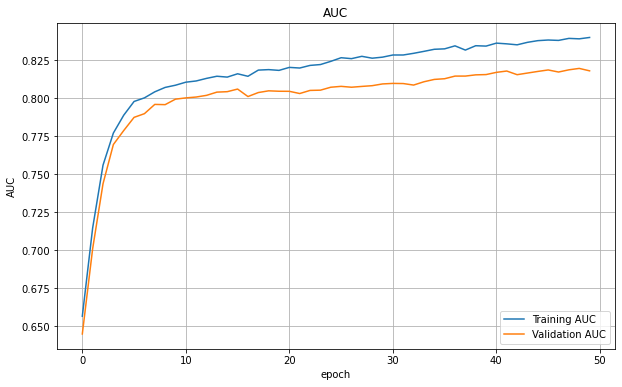

In [17]:
# plot auc
plt.figure(figsize=(10,6))
plt.title('AUC')
plt.plot(clf.history['train_auc'], label='Training AUC')
plt.plot(clf.history['valid_auc'], label='Validation AUC')
plt.legend(loc='lower right')
plt.ylabel('AUC')
plt.xlabel('epoch')
plt.grid(True);
plt.show();

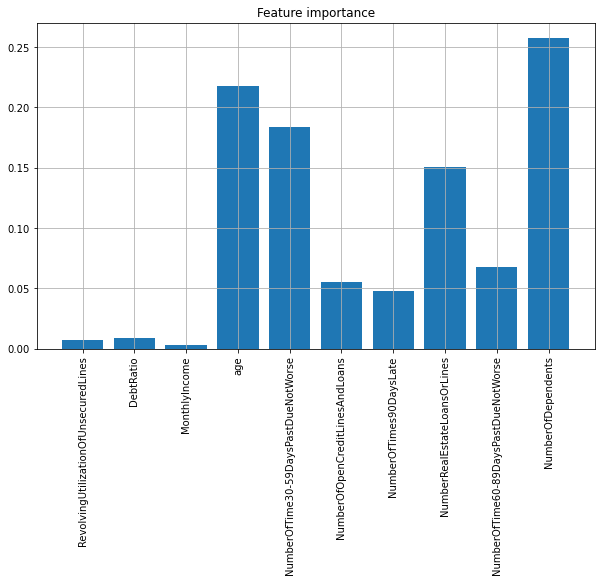

In [18]:
# let's look at feature importance
# plt.bar(x= range(len(clf.feature_importances_)), height=clf.feature_importances_, );
plt.figure(figsize=(10,6))
plt.xticks(rotation=90)
plt.title('Feature importance')
plt.bar(x= all_col_list, height=clf.feature_importances_, );
plt.grid(True);